In [1]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
import pandas as pd

In [2]:
#InputFiles For Error Calculations
outdir='/Users/paulrobustelli/Desktop/Manuscript_Files/asyn_4.2/BlockError_Calcs/'

Fasudil=np.loadtxt(outdir+'BlockError_InputFiles/Fasudil.AllInteractions.fulltraj.s1.dat')
Lig47=np.loadtxt(outdir+'BlockError_InputFiles/Lig47.TotaInt.s1.reorder.417.dat')
Fasudil_Y125=np.loadtxt(outdir+'BlockError_InputFiles/Lig_ring.0.Y125.stackparams.all.dat')
Fasudil_Y133=np.loadtxt(outdir+'BlockError_InputFiles/Lig_ring.0.Y133.stackparams.all.dat')
Fasudil_Y136=np.loadtxt(outdir+'BlockError_InputFiles/Lig_ring.0.Y136.stackparams.all.dat')
Lig47_Y125=np.loadtxt(outdir+'BlockError_InputFiles/Lig47.Lig_ring.0.Y125.stackparams.all.dat')
Lig47_Y133=np.loadtxt(outdir+'BlockError_InputFiles/Lig47.Lig_ring.0.Y133.stackparams.all.dat')
Lig47_Y136=np.loadtxt(outdir+'BlockError_InputFiles/Lig47.Lig_ring.0.Y136.stackparams.all.dat')
Fas_byres=np.loadtxt(outdir+'BlockError_InputFiles/Fasudil.res_contacts.dat')
L47_byres=np.loadtxt(outdir+'BlockError_InputFiles/Ligand47.res_contacts.dat')



In [54]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
sns.set_style("whitegrid")

In [55]:
def Kd_calc(bound,conc):
  return((1-bound)*conc/bound)

#https://github.com/computative/block/blob/master/python/tictoc.py
#https://journals.aps.org/pre/abstract/10.1103/PhysRevE.98.043304
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
    #    print("Warning: Data size = %g, is not a power of 2." % floor(2**d))
    #    print("Truncating data to %g." % 2**floor(d) )
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances 
    # for each blocking transformation
    for i in arange(0,d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]

    # we need a list of magic numbers
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    #if (k >= d-1):
        #print("Warning: Use more data")

    return (s[k]/2**(d-k))


def get_blockerrors(Data,bound_frac):
 n_data=len(Data[0])
 block_errors=[]
 ave=[]
 for i in range(0,n_data):
  data=Data[:,i]
  average=np.average(data)
  be=block(data)**.5
  ave.append(np.average(data))
  block_errors.append(be)
 ave_bf=np.asarray(ave)/bound_frac
 be_bf=np.asarray(block_errors)/bound_frac
   
 resnum=np.linspace(121, 140, num=20)
 start=0
 Hbond=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 start=1
 Charge=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 start=2
 Stack=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 start=3
 Hphob=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 return Hphob,Stack,Charge,Hbond 

def get_blockerrors_pyblock(Data,bound_frac):
 n_data=len(Data[0])
 block_errors=[]
 ave=[]
 for i in range(0,n_data):
  data=Data[:,i]
  average=np.average(data)
  if (average!=0) and (average!=1):
    reblock_data = pyblock.blocking.reblock(data)
    opt = pyblock.blocking.find_optimal_block(len(data), reblock_data)[0]
    opt_block=reblock_data[opt] 
    #print("optimal block:",opt_block)
    #print(opt_block[2],opt_block[4])
    be=opt_block[4]
  else:
   be=0
  ave.append(average)
  block_errors.append(be)

 ave_bf=np.asarray(ave)/bound_frac
 be_bf=np.asarray(block_errors)/bound_frac
 resnum=np.linspace(121, 140, num=20)
 start=0
 Hbond=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 start=1
 Charge=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 start=2
 Stack=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 start=3
 Hphob=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 return Hphob,Stack,Charge,Hbond 

def get_blockerrors_pyblock_maxerror(Data,bound_frac):
 n_data=len(Data[0])
 block_errors=[]
 ave=[]
 for i in range(0,n_data):
  be_max=0
  data=Data[:,i]
  average=np.average(data)
  if (average!=0) and (average!=1):
    reblock_data = pyblock.blocking.reblock(data)
    opt = pyblock.blocking.find_optimal_block(len(data), reblock_data)[0]
    be_opt=reblock_data[opt][4]
    be_max=be_opt
    for i in range(0,len(reblock_data)): 
     be=reblock_data[i][4]
     if(be > be_max):
       be_max=be
  else:
   be=0
  ave.append(average)
  block_errors.append(be_max)

 ave_bf=np.asarray(ave)/bound_frac
 be_bf=np.asarray(block_errors)/bound_frac
 resnum=np.linspace(121, 140, num=20)
 start=0
 Hbond=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 start=1
 Charge=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 start=2
 Stack=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 start=3
 Hphob=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 return Hphob,Stack,Charge,Hbond 


def get_blockerror(Data):
  data=Data
  average=np.average(data)
  be=block(data)**.5
  return average,be

def get_blockerror_pyblock(Data):
  average=np.average(Data)
  #print(average,Data,len(Data))  
  if (average!=0) and (average!=1):
   reblock_data = pyblock.blocking.reblock(Data)
   opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
   be=reblock_data[opt][4]
  else:
   be=0
  return average,float(be)

def get_blockerror_pyblock_max(Data):
  average=np.average(Data)
  if (average!=0) and (average!=1):
   reblock_data = pyblock.blocking.reblock(Data)
   be_max=0
   for i in range(0,len(reblock_data)): 
     be=reblock_data[i][4]
     if(be > be_max):
       be_max=be
  else:
   be=0
  return average,float(be)

11
optimal block: BlockTuple(block=11, ndata=542, mean=array(0.0118), cov=array(0.0002), std_err=array(0.0007), std_err_err=array(0.0000))
0.011826856549815499 0.0006629105475639663
0.011826856549815499 0.0006629105475639663 0.0007227926522235129


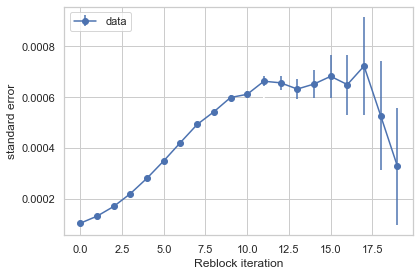

data                                                  
             mean standard error standard error error optimal block
reblock                                                            
0        0.011834       0.000103         6.883213e-08              
1        0.011834       0.000130         1.235454e-07              
2        0.011834       0.000169         2.262243e-07              
3        0.011834       0.000219         4.159194e-07              
4        0.011834       0.000280         7.522424e-07              
5        0.011834       0.000349         1.322910e-06              
6        0.011834       0.000421         2.259726e-06              
7        0.011819       0.000492         3.735845e-06              
8        0.011819       0.000542         5.820291e-06              
9        0.011821       0.000599         9.090437e-06              
10       0.011827       0.000611         1.313567e-05              
11       0.011827       0.000663         2.015307e-05      <---    
12       0.011827       0.000657         2.825461e-05              
13       0.011835       0.000632         3.860639e-05              
14       0.011891       0.000652         5.672998e-05              
15       0.011833       0.000682         8.527822e-05              
16       0.011628       0.000650         1.186219e-04              
17       0.011628       0.000723         1.931745e-04              
18       0.011628       0.000526         2.148799e-04              
19       0.011628       0.000327         2.313019e-04

In [56]:
reblock_data = pyblock.blocking.reblock(Fasudil[:,0])
opt = pyblock.blocking.find_optimal_block(len(Fasudil[:,0]), reblock_data)[0]
print(opt)
opt_block=reblock_data[opt]
print("optimal block:",opt_block)
print(opt_block[2],opt_block[4])

#Find Max Error
be_max=opt_block[4]
for i in range(0,len(reblock_data)): 
    be=reblock_data[i][4]
    if(be > be_max):
      be_max=be

print(opt_block[2],opt_block[4],be_max)

    
data_pd=pd.Series(Fasudil[:,0])
(data_length, reblock_data, covariance)=pyblock.pd_utils.reblock(data_pd)
pyblock.plot.plot_reblocking(reblock_data);
reblock_data

In [57]:
#Fasudil Errors
lig="Fasudil"
bound_frac=0.74489
Fas_hphob_pyb,Fas_stack_pyb,Fas_charge_pyb,Fas_hbond_pyb=get_blockerrors_pyblock(Fasudil,bound_frac)
Fas_hphob_pyb_max,Fas_stack_pyb_max,Fas_charge_pyb_max,Fas_hbond_pyb_max=get_blockerrors_pyblock_maxerror(Fasudil,bound_frac)

np.savetxt('%s/%s.stack.be.pyblock.dat'%(outdir,lig),Fas_stack_pyb,'%.4f')
np.savetxt('%s/%s.hphob.be.pyblock.dat'%(outdir,lig),Fas_hphob_pyb,'%.4f')
np.savetxt('%s/%s.charge.be.pyblock.dat'%(outdir,lig),Fas_charge_pyb,'%.4f')
np.savetxt('%s/%s.hbond.be.pyblock.dat'%(outdir,lig),Fas_hbond_pyb,'%.4f')

#Fasudil Errors
np.savetxt('%s/%s.stack.be.maxerror.pyblock.dat'%(outdir,lig),Fas_stack_pyb_max,'%.4f')
np.savetxt('%s/%s.hphob.be.maxerror.pyblock.dat'%(outdir,lig),Fas_hphob_pyb_max,'%.4f')
np.savetxt('%s/%s.charge.be.maxerror.pyblock.dat'%(outdir,lig),Fas_charge_pyb_max,'%.4f')
np.savetxt('%s/%s.hbond.be.maxerror.pyblock.dat'%(outdir,lig),Fas_hbond_pyb_max,'%.4f')

In [58]:
print("Fasudil")
print("Hphob Block Errors")
print(Fas_hphob_pyb)

print("Stack Block Errors")
print(Fas_stack_pyb)

print("Charge Block Errors")
print(Fas_charge_pyb)

print("Hbond Block Errors")
print(Fas_hbond_pyb)

Fasudil
Hphob Block Errors
[[121.0000 0.0220 0.0011]
 [122.0000 0.0315 0.0014]
 [123.0000 0.0616 0.0022]
 [124.0000 0.0430 0.0019]
 [125.0000 0.1636 0.0045]
 [126.0000 0.0756 0.0025]
 [127.0000 0.0864 0.0026]
 [128.0000 0.0683 0.0023]
 [129.0000 0.0408 0.0019]
 [130.0000 0.0682 0.0021]
 [131.0000 0.0694 0.0019]
 [132.0000 0.0313 0.0014]
 [133.0000 0.1786 0.0045]
 [134.0000 0.0847 0.0035]
 [135.0000 0.0935 0.0034]
 [136.0000 0.2029 0.0051]
 [137.0000 0.0919 0.0027]
 [138.0000 0.0617 0.0021]
 [139.0000 0.0741 0.0019]
 [140.0000 0.0474 0.0013]]
Stack Block Errors
[[121.0000 0.0000 0.0000]
 [122.0000 0.0000 0.0000]
 [123.0000 0.0000 0.0000]
 [124.0000 0.0000 0.0000]
 [125.0000 0.0417 0.0017]
 [126.0000 0.0000 0.0000]
 [127.0000 0.0000 0.0000]
 [128.0000 0.0000 0.0000]
 [129.0000 0.0000 0.0000]
 [130.0000 0.0000 0.0000]
 [131.0000 0.0000 0.0000]
 [132.0000 0.0000 0.0000]
 [133.0000 0.0408 0.0014]
 [134.0000 0.0000 0.0000]
 [135.0000 0.0000 0.0000]
 [136.0000 0.0477 0.0016]
 [137.0000 0.0000

In [59]:
print("Fasudil Max Error Blocks")
print("Hphob Block Errors")
print(Fas_hphob_pyb_max)

print("Stack Block Errors")
print(Fas_stack_pyb_max)

print("Charge Block Errors")
print(Fas_charge_pyb_max)

print("Hbond Block Errors")
print(Fas_hbond_pyb_max)

Fasudil Max Error Blocks
Hphob Block Errors
[[121.0000 0.0220 0.0011]
 [122.0000 0.0315 0.0014]
 [123.0000 0.0616 0.0025]
 [124.0000 0.0430 0.0028]
 [125.0000 0.1636 0.0058]
 [126.0000 0.0756 0.0026]
 [127.0000 0.0864 0.0026]
 [128.0000 0.0683 0.0023]
 [129.0000 0.0408 0.0029]
 [130.0000 0.0682 0.0022]
 [131.0000 0.0694 0.0021]
 [132.0000 0.0313 0.0017]
 [133.0000 0.1786 0.0079]
 [134.0000 0.0847 0.0049]
 [135.0000 0.0935 0.0052]
 [136.0000 0.2029 0.0093]
 [137.0000 0.0919 0.0034]
 [138.0000 0.0617 0.0027]
 [139.0000 0.0741 0.0024]
 [140.0000 0.0474 0.0015]]
Stack Block Errors
[[121.0000 0.0000 0.0000]
 [122.0000 0.0000 0.0000]
 [123.0000 0.0000 0.0000]
 [124.0000 0.0000 0.0000]
 [125.0000 0.0417 0.0023]
 [126.0000 0.0000 0.0000]
 [127.0000 0.0000 0.0000]
 [128.0000 0.0000 0.0000]
 [129.0000 0.0000 0.0000]
 [130.0000 0.0000 0.0000]
 [131.0000 0.0000 0.0000]
 [132.0000 0.0000 0.0000]
 [133.0000 0.0408 0.0027]
 [134.0000 0.0000 0.0000]
 [135.0000 0.0000 0.0000]
 [136.0000 0.0477 0.0019]


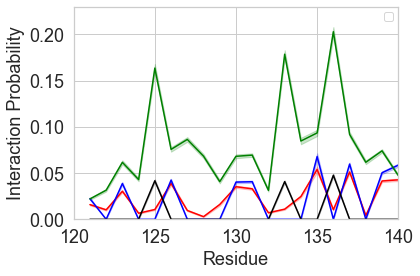

In [60]:
name="Fasudil"
sns.set(style='whitegrid')
Hbond=Fas_hbond_pyb
Charge=Fas_charge_pyb
Stack=Fas_stack_pyb
Hphob=Fas_hphob_pyb
HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]

#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],color='red',label='Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],color='blue',label='Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],color='black',label='Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],color='green',label='Hphob')

plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)

plt.ylim(0.0,0.23)

plt.xlim(120,140)
plt.xticks(range(120,141,5),fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel('Residue',fontsize=18)
plt.ylabel('Interaction Probability',fontsize=18)
#plt.legend(loc='upper left',fontsize=13)
plt.legend('')
plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.blockerrors.pyblock.pdf'%name, bbox_inches='tight')

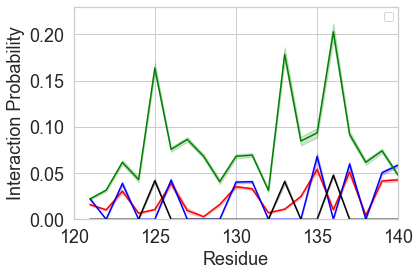

In [61]:
name="Fasudil"
sns.set(style='whitegrid')
Hbond=Fas_hbond_pyb_max
Charge=Fas_charge_pyb_max
Stack=Fas_stack_pyb_max
Hphob=Fas_hphob_pyb_max
HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]

#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],color='red',label='Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],color='blue',label='Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],color='black',label='Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],color='green',label='Hphob')

plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)

plt.ylim(0.0,0.23)

plt.xlim(120,140)
plt.xticks(range(120,141,5),fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel('Residue',fontsize=18)
plt.ylabel('Interaction Probability',fontsize=18)
#plt.legend(loc='upper left',fontsize=13)
plt.legend('')

plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.blockerrors.maxerror.pyblock.pdf'%name, bbox_inches='tight')

In [62]:
lig="L47"
bound_frac=0.83643
L47_hphob_pyb,L47_stack_pyb,L47_charge_pyb,L47_hbond_pyb=get_blockerrors_pyblock(Lig47,bound_frac)
L47_hphob_pyb_max,L47_stack_pyb_max,L47_charge_pyb_max,L47_hbond_pyb_max=get_blockerrors_pyblock_maxerror(Lig47,bound_frac)

np.savetxt('%s/%s.stack.be.pyblock.dat'%(outdir,lig),L47_stack_pyb,'%.4f')
np.savetxt('%s/%s.hphob.be.pyblock.dat'%(outdir,lig),L47_hphob_pyb,'%.4f')
np.savetxt('%s/%s.charge.be.pyblock.dat'%(outdir,lig),L47_charge_pyb,'%.4f')
np.savetxt('%s/%s.hbond.be.pyblock.dat'%(outdir,lig),L47_hbond_pyb,'%.4f')

np.savetxt('%s/%s.stack.be.maxerror.pyblock.dat'%(outdir,lig),L47_stack_pyb_max,'%.4f')
np.savetxt('%s/%s.hphob.be.maxerror.pyblock.dat'%(outdir,lig),L47_hphob_pyb_max,'%.4f')
np.savetxt('%s/%s.charge.be.maxerror.pyblock.dat'%(outdir,lig),L47_charge_pyb_max,'%.4f')
np.savetxt('%s/%s.hbond.be.maxerror.pyblock.dat'%(outdir,lig),L47_hbond_pyb_max,'%.4f')

In [63]:
print("Lig47 Block Errors")
print("Hphob Block Errors")
print(L47_hphob_pyb)

print("Stack Block Errors")
print(L47_stack_pyb)

print("Charge Block Errors")
print(L47_charge_pyb)

print("Hbond Block Errors")
print(L47_hbond_pyb)

Lig47 Block Errors
Hphob Block Errors
[[121.0000 0.0202 0.0010]
 [122.0000 0.0324 0.0015]
 [123.0000 0.0585 0.0023]
 [124.0000 0.0480 0.0026]
 [125.0000 0.2227 0.0073]
 [126.0000 0.0754 0.0026]
 [127.0000 0.1132 0.0051]
 [128.0000 0.0851 0.0032]
 [129.0000 0.0505 0.0027]
 [130.0000 0.0921 0.0044]
 [131.0000 0.0766 0.0032]
 [132.0000 0.0408 0.0021]
 [133.0000 0.2950 0.0099]
 [134.0000 0.1114 0.0110]
 [135.0000 0.1233 0.0051]
 [136.0000 0.2903 0.0101]
 [137.0000 0.1102 0.0059]
 [138.0000 0.0943 0.0118]
 [139.0000 0.0847 0.0127]
 [140.0000 0.0494 0.0088]]
Stack Block Errors
[[121.0000 0.0000 0.0000]
 [122.0000 0.0000 0.0000]
 [123.0000 0.0000 0.0000]
 [124.0000 0.0000 0.0000]
 [125.0000 0.0667 0.0033]
 [126.0000 0.0000 0.0000]
 [127.0000 0.0000 0.0000]
 [128.0000 0.0000 0.0000]
 [129.0000 0.0000 0.0000]
 [130.0000 0.0000 0.0000]
 [131.0000 0.0000 0.0000]
 [132.0000 0.0000 0.0000]
 [133.0000 0.0653 0.0029]
 [134.0000 0.0000 0.0000]
 [135.0000 0.0000 0.0000]
 [136.0000 0.0747 0.0058]
 [137.

In [64]:
print("Lig47 Max Error Blocks")
print("Hphob Block Errors")
print(L47_hphob_pyb_max)

print("Stack Block Errors")
print(L47_stack_pyb_max)

print("Charge Block Errors")
print(L47_charge_pyb_max)

print("Hbond Block Errors")
print(L47_hbond_pyb_max)

Lig47 Max Error Blocks
Hphob Block Errors
[[121.0000 0.0202 0.0011]
 [122.0000 0.0324 0.0017]
 [123.0000 0.0585 0.0025]
 [124.0000 0.0480 0.0032]
 [125.0000 0.2227 0.0090]
 [126.0000 0.0754 0.0030]
 [127.0000 0.1132 0.0061]
 [128.0000 0.0851 0.0040]
 [129.0000 0.0505 0.0068]
 [130.0000 0.0921 0.0051]
 [131.0000 0.0766 0.0085]
 [132.0000 0.0408 0.0026]
 [133.0000 0.2950 0.0117]
 [134.0000 0.1114 0.0112]
 [135.0000 0.1233 0.0061]
 [136.0000 0.2903 0.0141]
 [137.0000 0.1102 0.0069]
 [138.0000 0.0943 0.0123]
 [139.0000 0.0847 0.0136]
 [140.0000 0.0494 0.0095]]
Stack Block Errors
[[121.0000 0.0000 0.0000]
 [122.0000 0.0000 0.0000]
 [123.0000 0.0000 0.0000]
 [124.0000 0.0000 0.0000]
 [125.0000 0.0667 0.0037]
 [126.0000 0.0000 0.0000]
 [127.0000 0.0000 0.0000]
 [128.0000 0.0000 0.0000]
 [129.0000 0.0000 0.0000]
 [130.0000 0.0000 0.0000]
 [131.0000 0.0000 0.0000]
 [132.0000 0.0000 0.0000]
 [133.0000 0.0653 0.0038]
 [134.0000 0.0000 0.0000]
 [135.0000 0.0000 0.0000]
 [136.0000 0.0747 0.0088]
 [

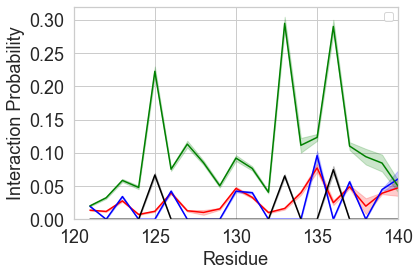

In [65]:
name="Lig47"
sns.set(style='whitegrid')
Hbond=L47_hbond_pyb
Charge=L47_charge_pyb
Stack=L47_stack_pyb
Hphob=L47_hphob_pyb
HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]

#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],color='red',label='Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],color='blue',label='Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],color='black',label='Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],color='green',label='Hphob')

plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)

plt.ylim(0.0,0.32)

plt.xlim(120,140)
plt.xticks(range(120,141,5),fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel('Residue',fontsize=18)
plt.ylabel('Interaction Probability',fontsize=18)
#plt.legend(loc='upper left',fontsize=13)
#plt.get_legend().remove()
plt.legend('')

plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.blockerrors.pyblock.pdf'%name, bbox_inches='tight')

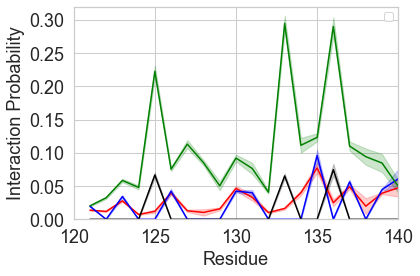

In [66]:
name="Lig47"
sns.set(style='whitegrid')
Hbond=L47_hbond_pyb_max
Charge=L47_charge_pyb_max
Stack=L47_stack_pyb_max
Hphob=L47_hphob_pyb_max
HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]

#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],color='red',label='Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],color='blue',label='Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],color='black',label='Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],color='green',label='Hphob')

plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)

plt.ylim(0.0,0.32)

plt.xlim(120,140)
plt.xticks(range(120,141,5),fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel('Residue',fontsize=18)
plt.ylabel('Interaction Probability',fontsize=18)
#plt.legend(loc='upper left',fontsize=13)
plt.legend('')

plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.blockerrors.maxerror.pyblock.pdf'%name, bbox_inches='tight')

In [67]:
Fasudil_D135=Fasudil[np.where(Fasudil[:,57]==1)]
np.shape(Fasudil_D135)
np.shape(Fasudil)

(1110889, 80)

In [68]:
#Conditional Probs with Pyblock
#(Res121) Hbond,Charge,Stack,Hphob, (Res 122)Hbond,Charge,Stack,Hphob 
#D135 Fasudil[:,59]
Fasudil_D135=Fasudil[np.where(Fasudil[:,57]==1)]
FasD135_hphob_pyb,FasD135_stack_pyb,FasD135_charge_pyb,FasD135_hbond_pyb=get_blockerrors_pyblock(Fasudil_D135,1.0)
FasD135_hphob_pyb_max,FasD135_stack_pyb_max,FasD135_charge_pyb_max,FasD135_hbond_pyb_max=get_blockerrors_pyblock_maxerror(Fasudil_D135,1.0)

lig="Fasudil_D135"
np.savetxt('%s/%s.stack.be.pyblock.dat'%(outdir,lig),FasD135_stack_pyb,'%.4f')
np.savetxt('%s/%s.hphob.be.pyblock.dat'%(outdir,lig),FasD135_hphob_pyb,'%.4f')
np.savetxt('%s/%s.charge.be.pyblock.dat'%(outdir,lig),FasD135_charge_pyb,'%.4f')
np.savetxt('%s/%s.hbond.be.pyblock.dat'%(outdir,lig),FasD135_hbond_pyb,'%.4f')

np.savetxt('%s/%s.stack.be.max.pyblock.dat'%(outdir,lig),FasD135_stack_pyb_max,'%.4f')
np.savetxt('%s/%s.hphob.be.max.pyblock.dat'%(outdir,lig),FasD135_hphob_pyb_max,'%.4f')
np.savetxt('%s/%s.charge.be.max.pyblock.dat'%(outdir,lig),FasD135_charge_pyb_max,'%.4f')
np.savetxt('%s/%s.hbond.be.max.pyblock.dat'%(outdir,lig),FasD135_hbond_pyb_max,'%.4f')

In [69]:
print("Fasudil D135 Block Error")
print("Hphob Block Errors")
print(FasD135_hphob_pyb)

print("Stack Block Errors")
print(FasD135_stack_pyb)

print("Charge Block Errors")
print(FasD135_charge_pyb)

print("Hbond Block Errors")
print(FasD135_hbond_pyb)

Fasudil D135 Block Error
Hphob Block Errors
[[121.0000 0.0040 0.0009]
 [122.0000 0.0151 0.0029]
 [123.0000 0.0145 0.0029]
 [124.0000 0.0195 0.0049]
 [125.0000 0.1275 0.0158]
 [126.0000 0.0411 0.0080]
 [127.0000 0.0616 0.0073]
 [128.0000 0.0493 0.0067]
 [129.0000 0.0264 0.0031]
 [130.0000 0.0379 0.0043]
 [131.0000 0.0477 0.0045]
 [132.0000 0.0279 0.0025]
 [133.0000 0.2389 0.0160]
 [134.0000 0.2029 0.0267]
 [135.0000 0.6386 0.0062]
 [136.0000 0.3182 0.0292]
 [137.0000 0.2022 0.0150]
 [138.0000 0.1005 0.0114]
 [139.0000 0.0596 0.0100]
 [140.0000 0.0096 0.0018]]
Stack Block Errors
[[121.0000 0.0000 0.0000]
 [122.0000 0.0000 0.0000]
 [123.0000 0.0000 0.0000]
 [124.0000 0.0000 0.0000]
 [125.0000 0.0317 0.0069]
 [126.0000 0.0000 0.0000]
 [127.0000 0.0000 0.0000]
 [128.0000 0.0000 0.0000]
 [129.0000 0.0000 0.0000]
 [130.0000 0.0000 0.0000]
 [131.0000 0.0000 0.0000]
 [132.0000 0.0000 0.0000]
 [133.0000 0.0470 0.0088]
 [134.0000 0.0000 0.0000]
 [135.0000 0.0000 0.0000]
 [136.0000 0.0291 0.0032]


In [70]:
print("Fasudil D135 Max Error Blocks")
print("Hphob Block Errors")
print(FasD135_hphob_pyb_max)

print("Stack Block Errors")
print(FasD135_stack_pyb_max)

print("Charge Block Errors")
print(FasD135_charge_pyb_max)

print("Hbond Block Errors")
print(FasD135_hbond_pyb_max)

Fasudil D135 Max Error Blocks
Hphob Block Errors
[[121.0000 0.0040 0.0017]
 [122.0000 0.0151 0.0034]
 [123.0000 0.0145 0.0035]
 [124.0000 0.0195 0.0051]
 [125.0000 0.1275 0.0183]
 [126.0000 0.0411 0.0123]
 [127.0000 0.0616 0.0085]
 [128.0000 0.0493 0.0097]
 [129.0000 0.0264 0.0032]
 [130.0000 0.0379 0.0043]
 [131.0000 0.0477 0.0045]
 [132.0000 0.0279 0.0025]
 [133.0000 0.2389 0.0180]
 [134.0000 0.2029 0.0284]
 [135.0000 0.6386 0.0089]
 [136.0000 0.3182 0.0319]
 [137.0000 0.2022 0.0209]
 [138.0000 0.1005 0.0134]
 [139.0000 0.0596 0.0160]
 [140.0000 0.0096 0.0021]]
Stack Block Errors
[[121.0000 0.0000 0.0000]
 [122.0000 0.0000 0.0000]
 [123.0000 0.0000 0.0000]
 [124.0000 0.0000 0.0000]
 [125.0000 0.0317 0.0069]
 [126.0000 0.0000 0.0000]
 [127.0000 0.0000 0.0000]
 [128.0000 0.0000 0.0000]
 [129.0000 0.0000 0.0000]
 [130.0000 0.0000 0.0000]
 [131.0000 0.0000 0.0000]
 [132.0000 0.0000 0.0000]
 [133.0000 0.0470 0.0118]
 [134.0000 0.0000 0.0000]
 [135.0000 0.0000 0.0000]
 [136.0000 0.0291 0.0

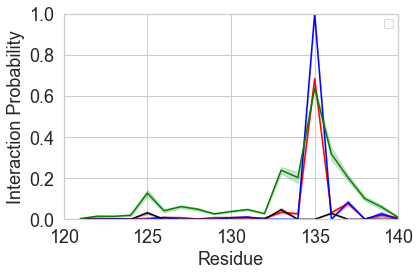

In [71]:
name="Fasudil_D135"
sns.set(style='whitegrid')
Hbond=FasD135_hbond_pyb
Charge=FasD135_charge_pyb
Stack=FasD135_stack_pyb
Hphob=FasD135_hphob_pyb
HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]

#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],color='red',label='Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],color='blue',label='Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],color='black',label='Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],color='green',label='Hphob')

plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)

plt.ylim(0.0,1.0)

plt.xlim(120,140)
plt.xticks(range(120,141,5),fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel('Residue',fontsize=18)
plt.ylabel('Interaction Probability',fontsize=18)
#plt.legend(loc='upper left',fontsize=13)
plt.legend('')
plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.blockerrors.pyblock.pdf'%name, bbox_inches='tight')

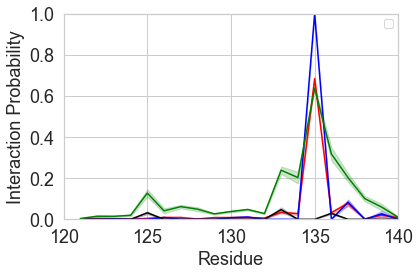

In [72]:
name="Fasudil_D135"
sns.set(style='whitegrid')
Hbond=FasD135_hbond_pyb_max
Charge=FasD135_charge_pyb_max
Stack=FasD135_stack_pyb_max
Hphob=FasD135_hphob_pyb_max
HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]

#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],color='red',label='Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],color='blue',label='Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],color='black',label='Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],color='green',label='Hphob')

plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)

plt.ylim(0.0,1.0)

plt.xlim(120,140)
plt.xticks(range(120,141,5),fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel('Residue',fontsize=18)
plt.ylabel('Interaction Probability',fontsize=18)
#plt.legend(loc='upper left',fontsize=13)
plt.legend('')
plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.blockerrors.pyblock.max.error.pdf'%name, bbox_inches='tight')

In [73]:
#Conditional Probs with Pyblock
#(Res121) Hbond,Charge,Stack,Hphob, (Res 122)Hbond,Charge,Stack,Hphob 
#D135 Fasudil[:,59]
Lig47_D135=Lig47[np.where(Lig47[:,57]==1)]
Lig47D135_hphob_pyb,Lig47D135_stack_pyb,Lig47D135_charge_pyb,Lig47D135_hbond_pyb=get_blockerrors_pyblock(Lig47_D135,1)
Lig47D135_hphob_pyb_max,Lig47D135_stack_pyb_max,Lig47D135_charge_pyb_max,Lig47D135_hbond_pyb_max=get_blockerrors_pyblock_maxerror(Lig47_D135,1)


lig="Lig47_D135"
np.savetxt('%s/%s.stack.be.pyblock.dat'%(outdir,lig),Lig47D135_stack_pyb,'%.4f')
np.savetxt('%s/%s.hphob.be.pyblock.dat'%(outdir,lig),Lig47D135_hphob_pyb,'%.4f')
np.savetxt('%s/%s.charge.be.pyblock.dat'%(outdir,lig),Lig47D135_charge_pyb,'%.4f')
np.savetxt('%s/%s.hbond.be.pyblock.dat'%(outdir,lig),Lig47D135_hbond_pyb,'%.4f')

np.savetxt('%s/%s.stack.be.max.pyblock.dat'%(outdir,lig),Lig47D135_stack_pyb_max,'%.4f')
np.savetxt('%s/%s.hphob.be.max.pyblock.dat'%(outdir,lig),Lig47D135_hphob_pyb_max,'%.4f')
np.savetxt('%s/%s.charge.be.max.pyblock.dat'%(outdir,lig),Lig47D135_charge_pyb_max,'%.4f')
np.savetxt('%s/%s.hbond.be.max.pyblock.dat'%(outdir,lig),Lig47D135_hbond_pyb_max,'%.4f')


In [74]:
print("Lig47 D135 Error ")
print("Hphob Block Errors")
print(Lig47D135_hphob_pyb)

print("Stack Block Errors")
print(Lig47D135_stack_pyb)

print("Charge Block Errors")
print(Lig47D135_charge_pyb)

print("Hbond Block Errors")
print(Lig47D135_hbond_pyb)

Lig47 D135 Error 
Hphob Block Errors
[[121.0000 0.0077 0.0032]
 [122.0000 0.0150 0.0028]
 [123.0000 0.0147 0.0031]
 [124.0000 0.0448 0.0102]
 [125.0000 0.1444 0.0227]
 [126.0000 0.0367 0.0065]
 [127.0000 0.1005 0.0410]
 [128.0000 0.0705 0.0178]
 [129.0000 0.0398 0.0080]
 [130.0000 0.0890 0.0214]
 [131.0000 0.0593 0.0080]
 [132.0000 0.0473 0.0076]
 [133.0000 0.4549 0.0414]
 [134.0000 0.2168 0.0199]
 [135.0000 0.5980 0.0067]
 [136.0000 0.4593 0.0358]
 [137.0000 0.1571 0.0140]
 [138.0000 0.1049 0.0113]
 [139.0000 0.0411 0.0043]
 [140.0000 0.0077 0.0012]]
Stack Block Errors
[[121.0000 0.0000 0.0000]
 [122.0000 0.0000 0.0000]
 [123.0000 0.0000 0.0000]
 [124.0000 0.0000 0.0000]
 [125.0000 0.0469 0.0124]
 [126.0000 0.0000 0.0000]
 [127.0000 0.0000 0.0000]
 [128.0000 0.0000 0.0000]
 [129.0000 0.0000 0.0000]
 [130.0000 0.0000 0.0000]
 [131.0000 0.0000 0.0000]
 [132.0000 0.0000 0.0000]
 [133.0000 0.0578 0.0052]
 [134.0000 0.0000 0.0000]
 [135.0000 0.0000 0.0000]
 [136.0000 0.1341 0.0322]
 [137.0

In [75]:
print("Lig47 D135 Max Error Blocks")
print("Hphob Block Errors")
print(Lig47D135_hphob_pyb_max)

print("Stack Block Errors")
print(Lig47D135_stack_pyb_max)

print("Charge Block Errors")
print(Lig47D135_charge_pyb_max)

print("Hbond Block Errors")
print(Lig47D135_hbond_pyb_max)

Lig47 D135 Max Error Blocks
Hphob Block Errors
[[121.0000 0.0077 0.0054]
 [122.0000 0.0150 0.0053]
 [123.0000 0.0147 0.0065]
 [124.0000 0.0448 0.0123]
 [125.0000 0.1444 0.0473]
 [126.0000 0.0367 0.0165]
 [127.0000 0.1005 0.0451]
 [128.0000 0.0705 0.0202]
 [129.0000 0.0398 0.0104]
 [130.0000 0.0890 0.0267]
 [131.0000 0.0593 0.0091]
 [132.0000 0.0473 0.0158]
 [133.0000 0.4549 0.0689]
 [134.0000 0.2168 0.0318]
 [135.0000 0.5980 0.0239]
 [136.0000 0.4593 0.0492]
 [137.0000 0.1571 0.0175]
 [138.0000 0.1049 0.0132]
 [139.0000 0.0411 0.0059]
 [140.0000 0.0077 0.0015]]
Stack Block Errors
[[121.0000 0.0000 0.0000]
 [122.0000 0.0000 0.0000]
 [123.0000 0.0000 0.0000]
 [124.0000 0.0000 0.0000]
 [125.0000 0.0469 0.0353]
 [126.0000 0.0000 0.0000]
 [127.0000 0.0000 0.0000]
 [128.0000 0.0000 0.0000]
 [129.0000 0.0000 0.0000]
 [130.0000 0.0000 0.0000]
 [131.0000 0.0000 0.0000]
 [132.0000 0.0000 0.0000]
 [133.0000 0.0578 0.0083]
 [134.0000 0.0000 0.0000]
 [135.0000 0.0000 0.0000]
 [136.0000 0.1341 0.045

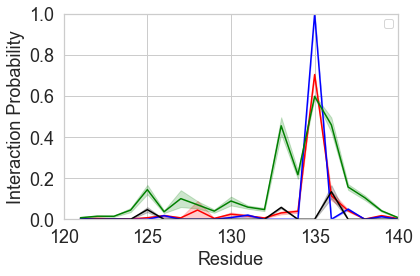

In [76]:
name="Lig47_D135"
sns.set(style='whitegrid')
Hbond=Lig47D135_hbond_pyb
Charge=Lig47D135_charge_pyb
Stack=Lig47D135_stack_pyb
Hphob=Lig47D135_hphob_pyb
HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]

#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],color='red',label='Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],color='blue',label='Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],color='black',label='Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],color='green',label='Hphob')

plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)

plt.ylim(0.0,1.0)

plt.xlim(120,140)
plt.xticks(range(120,141,5),fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel('Residue',fontsize=18)
plt.ylabel('Interaction Probability',fontsize=18)
plt.legend(loc='upper left',fontsize=13)
plt.legend('')
plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.blockerrors.pyblock.pdf'%name, bbox_inches='tight')

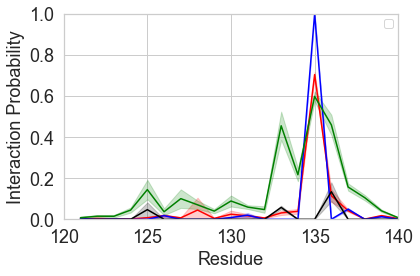

In [77]:
name="Lig47_D135"
sns.set(style='whitegrid')
Hbond=Lig47D135_hbond_pyb_max
Charge=Lig47D135_charge_pyb_max
Stack=Lig47D135_stack_pyb_max
Hphob=Lig47D135_hphob_pyb_max
HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]

#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],color='red',label='Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],color='blue',label='Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],color='black',label='Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],color='green',label='Hphob')

plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)

plt.ylim(0.0,1.0)

plt.xlim(120,140)
plt.xticks(range(120,141,5),fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel('Residue',fontsize=18)
plt.ylabel('Interaction Probability',fontsize=18)
plt.legend(loc='upper left',fontsize=13)
plt.legend('')
plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.blockerrors.pyblock.max_error.pdf'%name, bbox_inches='tight')

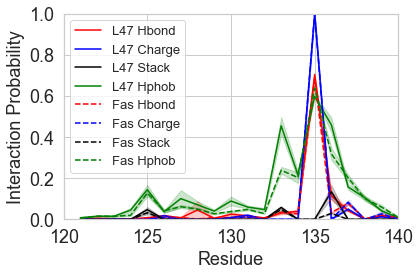

In [78]:
name="Lig47_Fasudil_D135"
sns.set(style='whitegrid')
Hbond=Lig47D135_hbond_pyb
Charge=Lig47D135_charge_pyb
Stack=Lig47D135_stack_pyb
Hphob=Lig47D135_hphob_pyb
#Hbond[14]=[135,0,0]
#Charge[14]=[135,0,0]
#Stack[14]=[135,0,0]
#Hphob[14]=[135,0,0]
HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]


#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],color='red',label='L47 Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],color='blue',label='L47 Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],color='black',label='L47 Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],color='green',label='L47 Hphob')
plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)


Hbond=FasD135_hbond_pyb
Charge=FasD135_charge_pyb
Stack=FasD135_stack_pyb
Hphob=FasD135_hphob_pyb
#Hbond[14]=[135,0,0]
#Charge[14]=[135,0,0]
#Stack[14]=[135,0,0]
#Hphob[14]=[135,0,0]

HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]

#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],linestyle='dashed',color='red',label='Fas Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],linestyle='dashed',color='blue',label='Fas Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],linestyle='dashed',color='black',label='Fas Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],linestyle='dashed',color='green',label='Fas Hphob')
plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)


plt.ylim(0.0,1.0)

plt.xlim(120,140)
plt.xticks(range(120,141,5),fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel('Residue',fontsize=18)
plt.ylabel('Interaction Probability',fontsize=18)
plt.legend(loc='upper left',fontsize=13)
plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.blockerrors.pyblock.pdf'%name, bbox_inches='tight')

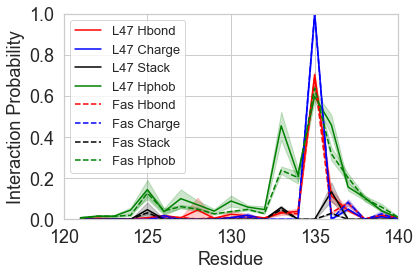

In [79]:
name="Lig47_Fasudil_D135"
sns.set(style='whitegrid')
Hbond=Lig47D135_hbond_pyb_max
Charge=Lig47D135_charge_pyb_max
Stack=Lig47D135_stack_pyb_max
Hphob=Lig47D135_hphob_pyb_max
#Hbond[14]=[135,0,0]
#Charge[14]=[135,0,0]
#Stack[14]=[135,0,0]
#Hphob[14]=[135,0,0]
HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]


#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],color='red',label='L47 Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],color='blue',label='L47 Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],color='black',label='L47 Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],color='green',label='L47 Hphob')
plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)


Hbond=FasD135_hbond_pyb_max
Charge=FasD135_charge_pyb_max
Stack=FasD135_stack_pyb_max
Hphob=FasD135_hphob_pyb_max
#Hbond[14]=[135,0,0]
#Charge[14]=[135,0,0]
#Stack[14]=[135,0,0]
#Hphob[14]=[135,0,0]

HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]

#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],linestyle='dashed',color='red',label='Fas Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],linestyle='dashed',color='blue',label='Fas Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],linestyle='dashed',color='black',label='Fas Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],linestyle='dashed',color='green',label='Fas Hphob')
plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)


plt.ylim(0.0,1.0)

plt.xlim(120,140)
plt.xticks(range(120,141,5),fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel('Residue',fontsize=18)
plt.ylabel('Interaction Probability',fontsize=18)
plt.legend(loc='upper left',fontsize=13)
plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.blockerrors.pyblock.maxerror.pdf'%name, bbox_inches='tight')

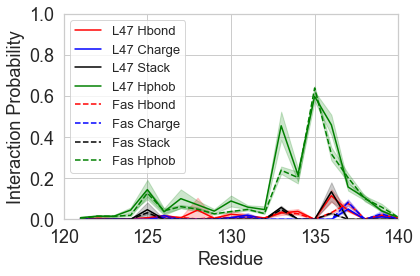

In [80]:
name="Lig47_Fasudil_D135"
sns.set(style='whitegrid')
Hbond=Lig47D135_hbond_pyb_max
Charge=Lig47D135_charge_pyb_max
Stack=Lig47D135_stack_pyb_max
Hphob=Lig47D135_hphob_pyb_max
Hbond[14]=[135,0,0]
Charge[14]=[135,0,0]
#Stack[14]=[135,0,0]
#Hphob[14]=[135,0,0]
HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]


#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],color='red',label='L47 Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],color='blue',label='L47 Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],color='black',label='L47 Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],color='green',label='L47 Hphob')
plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)


Hbond=FasD135_hbond_pyb_max
Charge=FasD135_charge_pyb_max
Stack=FasD135_stack_pyb_max
Hphob=FasD135_hphob_pyb_max
Hbond[14]=[135,0,0]
Charge[14]=[135,0,0]
#Stack[14]=[135,0,0]
#Hphob[14]=[135,0,0]

HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]

#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],linestyle='dashed',color='red',label='Fas Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],linestyle='dashed',color='blue',label='Fas Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],linestyle='dashed',color='black',label='Fas Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],linestyle='dashed',color='green',label='Fas Hphob')
plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)


plt.ylim(0.0,1.0)

plt.xlim(120,140)
plt.xticks(range(120,141,5),fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel('Residue',fontsize=18)
plt.ylabel('Interaction Probability',fontsize=18)
plt.legend(loc='upper left',fontsize=13)
plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.blockerrors.pyblock.pdf'%name, bbox_inches='tight')

In [81]:
#np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

def stack_errors(stackdata,name):
 dist=stackdata[:,0]
 alphas=stackdata[:,1]
 betas=stackdata[:,2]
 quadrant=np.zeros(len(dist)) 

 contacts=np.where(dist<0.5)
 a=np.where(alphas >= 135)
 b=np.where(alphas <= 45)
 c=np.where(betas >= 135)
 d=np.where(betas <= 45)
 q1=np.intersect1d(b,c)
 q2=np.intersect1d(a,c)
 q3=np.intersect1d(b,d)
 q4=np.intersect1d(a,d)
 q1_stack=np.intersect1d(q1,contacts)
 q2_stack=np.intersect1d(q2,contacts)
 q3_stack=np.intersect1d(q3,contacts)
 q4_stack=np.intersect1d(q4,contacts)

 quadrant1=np.zeros(len(dist))
 quadrant1[q1_stack]=1
 quadrant2=np.zeros(len(dist))
 quadrant2[q2_stack]=1
 quadrant3=np.zeros(len(dist))
 quadrant3[q3_stack]=1
 quadrant4=np.zeros(len(dist))
 quadrant4[q4_stack]=1
 allstacked=quadrant1+quadrant2+quadrant3+quadrant4
 total_stacked=len(q1)+len(q2)+len(q3)+len(q4)
 allstacked_frac,allstacked_frac_be=get_blockerror_pyblock(allstacked)
 #print(quadrant1,np.shape(quadrant1),len(quadrant))
 q1_frac,q1_frac_be=get_blockerror_pyblock(quadrant1)
 q2_frac,q2_frac_be=get_blockerror_pyblock(quadrant2)
 q3_frac,q3_frac_be=get_blockerror_pyblock(quadrant3)
 q4_frac,q4_frac_be=get_blockerror_pyblock(quadrant4) 

 print(name)
 print("all stacked:",allstacked_frac,"+_",allstacked_frac_be)
 print("q1:",q1_frac/allstacked_frac,"+_",q1_frac_be/allstacked_frac)
 print("q2:",q2_frac/allstacked_frac,"+_",q2_frac_be/allstacked_frac)
 print("q3:",q3_frac/allstacked_frac,"+_",q3_frac_be/allstacked_frac)
 print("q4:",q4_frac/allstacked_frac,"+_",q4_frac_be/allstacked_frac) 

 print(np.asarray([q1_frac/allstacked_frac,q2_frac/allstacked_frac,q3_frac/allstacked_frac,q4_frac/allstacked_frac]))
 print(np.asarray([q1_frac_be/allstacked_frac,q2_frac_be/allstacked_frac,q3_frac_be/allstacked_frac,q4_frac_be/allstacked_frac]))

def stack_errors_conditional(stackdata,cond_data_indices,name):
 dist=stackdata[:,0]
 alphas=stackdata[:,1]
 betas=stackdata[:,2]
 quadrant=np.zeros(len(dist)) 
 contacts=np.where(dist<0.5)
 cond_contacts=np.intersect1d(contacts,cond_data_indices)
 print(len(cond_contacts))

 a=np.where(alphas >= 135)
 b=np.where(alphas <= 45)
 c=np.where(betas >= 135)
 d=np.where(betas <= 45)
 q1=np.intersect1d(b,c)
 q2=np.intersect1d(a,c)
 q3=np.intersect1d(b,d)
 q4=np.intersect1d(a,d)
 q1_stack=np.intersect1d(q1,cond_contacts)
 q2_stack=np.intersect1d(q2,cond_contacts)
 q3_stack=np.intersect1d(q3,cond_contacts)
 q4_stack=np.intersect1d(q4,cond_contacts)
 quadrant1=np.zeros(len(dist))
 quadrant1[q1_stack]=1
 quadrant2=np.zeros(len(dist))
 quadrant2[q2_stack]=1
 quadrant3=np.zeros(len(dist))
 quadrant3[q3_stack]=1
 quadrant4=np.zeros(len(dist))
 quadrant4[q4_stack]=1
 allstacked=quadrant1+quadrant2+quadrant3+quadrant4
 total_stacked=len(q1)+len(q2)+len(q3)+len(q4)
 allstacked_frac,allstacked_frac_be=get_blockerror_pyblock(allstacked)
 q1_frac,q1_frac_be=get_blockerror_pyblock(quadrant1)
 q2_frac,q2_frac_be=get_blockerror_pyblock(quadrant2)
 q3_frac,q3_frac_be=get_blockerror_pyblock(quadrant3)
 q4_frac,q4_frac_be=get_blockerror_pyblock(quadrant4) 

 print(name)
 print("all stacked:",allstacked_frac,"+_",allstacked_frac_be)
 print("q1:",q1_frac/allstacked_frac,"+_",q1_frac_be/allstacked_frac)
 print("q2:",q2_frac/allstacked_frac,"+_",q2_frac_be/allstacked_frac)
 print("q3:",q3_frac/allstacked_frac,"+_",q3_frac_be/allstacked_frac)
 print("q4:",q4_frac/allstacked_frac,"+_",q4_frac_be/allstacked_frac) 

 print(np.asarray([q1_frac/allstacked_frac,q2_frac/allstacked_frac,q3_frac/allstacked_frac,q4_frac/allstacked_frac]))
 print(np.asarray([q1_frac_be/allstacked_frac,q2_frac_be/allstacked_frac,q3_frac_be/allstacked_frac,q4_frac_be/allstacked_frac]))

In [82]:
Fasudil_D135

Fasudil_D135=np.where(Fasudil[:,57]==1)[0]
np.shape(Fasudil_Y125[Fasudil_D135])

(56164, 3)

In [83]:
stack_errors(Fasudil_Y125,"Fasudil_Y125")
stack_errors(Fasudil_Y133,"Fasudil_Y133")
stack_errors(Fasudil_Y136,"Fasudil_Y136")

stack_errors_conditional(Fasudil_Y125,Fasudil_D135,"Lig47_Y125_D135")
stack_errors_conditional(Fasudil_Y133,Fasudil_D135,"Lig47_Y133_D135")
stack_errors_conditional(Fasudil_Y136,Fasudil_D135,"Lig47_Y136_D135")

#stack_errors_nodist(Fasudil_Y125_D135,"Fasudil_Y125_D135")
#stack_errors_nodist(Fasudil_Y133_D135,"Fasudil_Y133_D135")
#stack_errors_nodist(Fasudil_Y136_D135,"Fasudil_Y136_D135")

Fasudil_Y125
all stacked: 0.031046306156600704 +_ 0.0012655650532231756
q1: 0.22581112818579838 +_ 0.014815591211128925
q2: 0.25941604569572907 +_ 0.020350115518366123
q3: 0.2715938415146858 +_ 0.02416206307226026
q4: 0.24317898460378673 +_ 0.01582246452727588
[0.2258 0.2594 0.2716 0.2432]
[0.0148 0.0204 0.0242 0.0158]
Fasudil_Y133
all stacked: 0.030370271017176334 +_ 0.0010771395688978463
q1: 0.25084474479815044 +_ 0.015732519283769248
q2: 0.22879245954117017 +_ 0.01407746582931526
q3: 0.25422372399075227 +_ 0.01544290239382259
q4: 0.26613907166992706 +_ 0.020794666280920183
[0.2508 0.2288 0.2542 0.2661]
[0.0157 0.0141 0.0154 0.0208]
Fasudil_Y136
all stacked: 0.03550129670921217 +_ 0.0012104768168337743
q1: 0.22714133576753384 +_ 0.015612649854513085
q2: 0.24509356458238246 +_ 0.01504806052914359
q3: 0.2737968456818297 +_ 0.019360733848604303
q4: 0.253968253968254 +_ 0.017590956416608395
[0.2271 0.2451 0.2738 0.2540]
[0.0156 0.0150 0.0194 0.0176]
2824
Lig47_Y125_D135
all stacked: 0.00

In [84]:
Lig47_D135=np.where(Lig47[:,57]==1)[0]
np.shape(Fasudil_Y125[Lig47_D135])

(89172, 3)

In [85]:
stack_errors(Lig47_Y125,"Lig47_Y125")
stack_errors(Lig47_Y133,"Lig47_Y133")
stack_errors(Lig47_Y136,"Lig47_Y136")

stack_errors_conditional(Lig47_Y125,Lig47_D135,"Lig47_Y125_D135")
stack_errors_conditional(Lig47_Y133,Lig47_D135,"Lig47_Y133_D135")
stack_errors_conditional(Lig47_Y136,Lig47_D135,"Lig47_Y136_D135")

Lig47_Y125
all stacked: 0.055749944413888336 +_ 0.002768521392037969
q1: 0.2269747464961571 +_ 0.017787329816609996
q2: 0.24491377639992248 +_ 0.024141466175797256
q3: 0.2643060130465672 +_ 0.026267524165109246
q4: 0.2638054640573532 +_ 0.026489310976004543
[0.2270 0.2449 0.2643 0.2638]
[0.0178 0.0241 0.0263 0.0265]
Lig47_Y133
all stacked: 0.054571608864612035 +_ 0.0024368145423219866
q1: 0.2876795935536018 +_ 0.026183704481192966
q2: 0.24076670570575526 +_ 0.018048521014238515
q3: 0.2531712386388004 +_ 0.02087087232118747
q4: 0.21838246210184253 +_ 0.01555227165103718
[0.2877 0.2408 0.2532 0.2184]
[0.0262 0.0180 0.0209 0.0156]
Lig47_Y136
all stacked: 0.06246618699077946 +_ 0.004868045718878609
q1: 0.2189269811076045 +_ 0.016077096806169703
q2: 0.2709927514302595 +_ 0.021718253338107764
q3: 0.2513221794705518 +_ 0.03426538512023576
q4: 0.2587580879915841 +_ 0.04503917293457502
[0.2189 0.2710 0.2513 0.2588]
[0.0161 0.0217 0.0343 0.0450]
5971
Lig47_Y125_D135
all stacked: 0.00376725307388

In [86]:
Fas_contact=np.sum(Fas_byres,axis=1)
Fasudil_contact_frames=np.where(Fas_contact>0)
Fasudil_contact_binary=np.where(Fas_contact>0,1,0)
Fas_boundfrac=len(Fasudil_contact_frames[0])/len(Fas_contact)

L47_contact=np.sum(L47_byres,axis=1)
L47_contact_frames=np.where(L47_contact>0)
L47_contact_binary=np.where(L47_contact>0,1,0)
L47_boundfrac=len(L47_contact_frames[0])/len(L47_contact)


In [87]:
def Kd_calc(bound,conc):
  return((1-bound)*conc/bound)

In [88]:
#KD Calculation
#In nM
#Alberts number for Fasudil+Lig47=42.55A = 4.255nM
Box_L=4.255
#Box_L=Unit_Cell_Dimensions[0][0]
#Convert nM to meters for Box_V in M^3
Box_V=(Box_L*10**-9)**3
#Convert Box_V to L
Box_V_L=Box_V*1000
#Concentraion in Mols/L
Concentration=1/(Box_V_L*(6.023*10**23))
b=Fas_boundfrac
ub=1-b
#Kd=ub*Concentration/b
Kd=Kd_calc(b,Concentration)
print("Fasudil","L:",Box_L,"V:",Box_V,"Conc:",Concentration,"Kd (M):",Kd)
b=L47_boundfrac
Kd=Kd_calc(b,Concentration)
print("Ligand 47","L:",Box_L,"V:",Box_V,"Conc:",Concentration,"Kd (M):",Kd)


Fasudil L: 4.255 V: 7.7036881375e-26 Conc: 0.02155204293530307 Kd (M): 0.007532779052164851
Ligand 47 L: 4.255 V: 7.7036881375e-26 Conc: 0.02155204293530307 Kd (M): 0.004324771537638048


In [89]:
Fas_boundfrac,Fas_boundfrac_be=get_blockerror_pyblock(Fasudil_contact_binary)
L47_boundfrac,L47_boundfrac_be=get_blockerror_pyblock(L47_contact_binary)
print("Fasudil Bound Fraction:",Fas_boundfrac,"+_",Fas_boundfrac_be)
print("Lig47 Bound Fraction:",L47_boundfrac,"+_",L47_boundfrac_be)
F_upper=Fas_boundfrac+Fas_boundfrac_be
F_KD=Kd_calc(Fas_boundfrac,Concentration)
F_KD_upper=Kd_calc(F_upper,Concentration)
F_KD_error=F_KD-F_KD_upper

L47_upper=L47_boundfrac+L47_boundfrac_be
L47_KD=Kd_calc(L47_boundfrac,Concentration)
L47_KD_upper=Kd_calc(L47_upper,Concentration)
L47_KD_error=L47_KD-L47_KD_upper

print("Fasudil KD (mM):",F_KD*1000,"+_",F_KD_error*1000)
print("Lig47 KD (mM):",L47_KD*1000,"+_",L47_KD_error*1000)

Fasudil Bound Fraction: 0.7410065272047882 +_ 0.0028230799319944903
Lig47 Bound Fraction: 0.8328707908710952 +_ 0.003410126848606853
Fasudil KD (mM): 7.532779052164852 +_ 0.1103865408026896
Lig47 KD (mM): 4.324771537638048 +_ 0.10551863365627044


In [90]:
#Time Series of KD Calculations
time=np.linspace(0,200,len(Fasudil_contact_binary))
boundfrac_by_frame=[]
t=[]
err_by_frame=[]
err_upper=[]
err_lower=[]
stride=1000
Concentration=0.02155204293530307
for i in range(1000,len(Fasudil_contact_binary),1000):
    Data=np.asarray(Fasudil_contact_binary[0:i])
    bf,be=get_blockerror_pyblock_max(Data)
    boundfrac_by_frame.append(bf)
    err_by_frame.append(be)
    err_upper.append(bf-be)
    err_lower.append(bf+be)
    t.append(time[i])
    
Fas_Kd=Kd_calc(np.asarray(boundfrac_by_frame),Concentration)*1000
Fas_Kd_upper=Kd_calc(np.asarray(err_upper),Concentration)*1000
Fas_Kd_lower=Kd_calc(np.asarray(err_lower),Concentration)*1000
np.savetxt('%s/Lig47.KD.timecourse.errors.dat'%(outdir),np.column_stack((t,Fas_Kd,Fas_Kd_upper,Fas_Kd_lower)),'%.4f')


In [91]:
#Time Series of KD Calculations
time=np.linspace(0,200,len(L47_contact_binary))
boundfrac_by_frame=[]
t=[]
err_by_frame=[]
err_upper=[]
err_lower=[]
stride=1000
Concentration=0.02155204293530307
for i in range(1000,len(L47_contact_binary),1000):
    Data=np.asarray(L47_contact_binary[0:i])
    bf,be=get_blockerror_pyblock_max(Data)
    boundfrac_by_frame.append(bf)
    err_by_frame.append(be)
    err_upper.append(bf-be)
    err_lower.append(bf+be)
    t.append(time[i])
    
L47_Kd=Kd_calc(np.asarray(boundfrac_by_frame),Concentration)*1000
L47_Kd_upper=Kd_calc(np.asarray(err_upper),Concentration)*1000
L47_Kd_lower=Kd_calc(np.asarray(err_lower),Concentration)*1000
np.savetxt('%s/Lig47.KD.timecourse.errors.dat'%(outdir),np.column_stack((t,L47_Kd,L47_Kd_upper,L47_Kd_lower)),'%.4f')


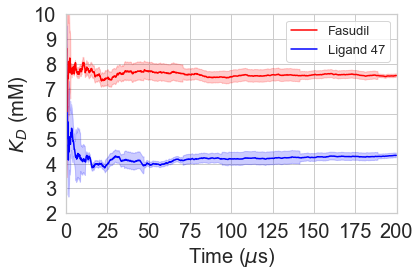

In [92]:
#KD_upper=err_upper
plt.plot(t,Fas_Kd,color='red',label='Fasudil')
plt.plot(t,L47_Kd,color='blue',label='Ligand 47')
plt.fill_between(t, Fas_Kd_upper, Fas_Kd_lower, color='red', alpha=0.2)
plt.fill_between(t, L47_Kd_upper, L47_Kd_lower, color='blue', alpha=0.2)

plt.yticks(fontsize=20) 
plt.xticks(fontsize=20) 
plt.xlabel('Time ($\mu$s)',fontsize=20)
plt.ylabel('$K_D$ (mM)',fontsize=20)
plt.legend(loc='upper right',fontsize=13)
plt.grid(True)
plt.ylim(2.0,10.0)
plt.xlim(0,200)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'KD.bytime.blockerrors.pdf', bbox_inches='tight')

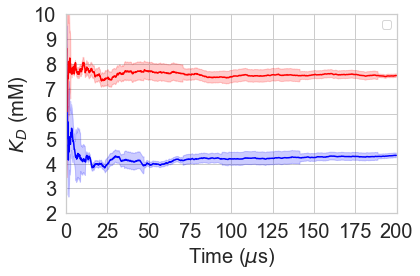

In [93]:
#KD_upper=err_upper
plt.plot(t,Fas_Kd,color='red',label='Fasudil')
plt.plot(t,L47_Kd,color='blue',label='Ligand 47')
plt.fill_between(t, Fas_Kd_upper, Fas_Kd_lower, color='red', alpha=0.2)
plt.fill_between(t, L47_Kd_upper, L47_Kd_lower, color='blue', alpha=0.2)

plt.yticks(fontsize=20) 
plt.xticks(fontsize=20) 
plt.xlabel('Time ($\mu$s)',fontsize=20)
plt.ylabel('$K_D$ (mM)',fontsize=20)
plt.legend(loc='upper right',fontsize=13)
plt.legend('')
plt.grid(True)
plt.ylim(2.0,10.0)
plt.xlim(0,200)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'KD.bytime.blockerrors.pdf', bbox_inches='tight')

In [94]:
#KD Calculation
#In nM
#Alberts number for Fasudil+Lig47=42.55A = 4.255nM
Box_L=5.3
#Box_L=Unit_Cell_Dimensions[0][0]
#Convert nM to meters for Box_V in M^3
Box_V=(Box_L*10**-9)**3
#Convert Box_V to L
Box_V_L=Box_V*1000
#Concentraion in Mols/L
Concentration=1/(Box_V_L*(6.023*10**23))
b=Fas_boundfrac
ub=1-b
#Kd=ub*Concentration/b
Kd=Kd_calc(b,Concentration)
print("Fasudil","L:",Box_L,"V:",Box_V,"Conc:",Concentration,"Kd (M):",Kd)
b=L47_boundfrac
Kd=Kd_calc(b,Concentration)
print("Ligand 47","L:",Box_L,"V:",Box_V,"Conc:",Concentration,"Kd (M):",Kd)


Fasudil L: 5.3 V: 1.4887700000000002e-25 Conc: 0.011152173774295891 Kd (M): 0.0038978606921533116
Ligand 47 L: 5.3 V: 1.4887700000000002e-25 Conc: 0.011152173774295891 Kd (M): 0.0022378669097241253


In [272]:
bound=0
n=0
res_time=[]

for i in range(1,len(Fasudil_contact_binary)):
    if Fasudil_contact_binary[i]==1:
     if bound==0:
      bound=1
     n+=1
    if Fasudil_contact_binary[i]==0:
     bound=0   
     if Fasudil_contact_binary[i-1]!=0:
      res_time.append(n)
      #print(res_time[-1],len(res_time))
      n=0
    #print(i,bound,Fasudil_contact_binary[i],Fasudil_contact_binary[i-1])
    
print("Fasudil Binding Events:",len(res_time),"Average Residence Time:",np.average(res_time)*0.18)

Fasudil Binding Events: 48904 Average Residence Time: 3.0298478652052996


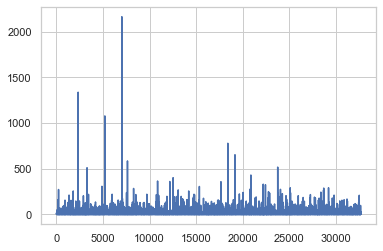

In [273]:
Fas_res_time_ns=np.asarray(res_time)*.180
plt.plot(res_time_ns)
plt.show()


5.096325406298779


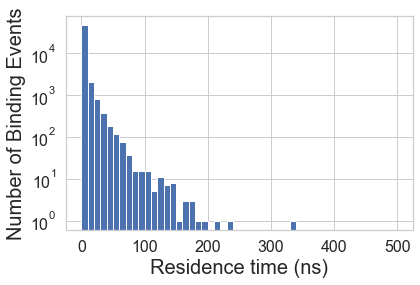

In [278]:
print(np.average(res_time_ns))
x0=0
xmax=500
histogram=plt.hist(Fas_res_time_ns,range=[x0,xmax],bins=50)

plt.yticks(fontsize=16) 
plt.xticks(fontsize=16) 
plt.xlabel('Residence time (ns)',fontsize=20)
plt.ylabel('Number of Binding Events',fontsize=20)
plt.yscale('log')
plt.tight_layout()


In [265]:
bound=0
n=0
res_time=[]
for i in range(1,len(L47_contact_binary)):
    if L47_contact_binary[i]==1:
     if bound==0:
      bound=1
     n+=1
    if L47_contact_binary[i]==0:
     if L47_contact_binary[i-1]!=0:
      bound=0
      res_time.append(n)
      n=0
    
    
print("Lig47 Binding Events:",len(res_time),"Average Residence Time:",np.average(res_time)*0.18)

Lig47 Binding Events: 32673 Average Residence Time: 5.096325406298779


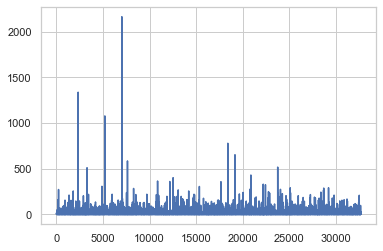

In [266]:
#Each frame is .180ns
L47_res_time_ns=np.asarray(res_time)*.180
plt.plot(L47_res_time_ns)
plt.show()

5.096325406298779


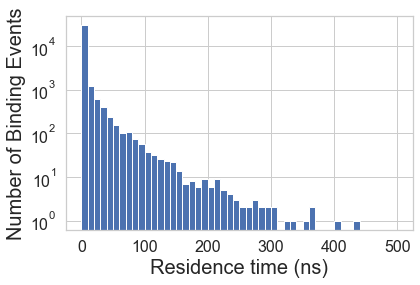

In [279]:
print(np.average(L47_res_time_ns))
x0=0
xmax=500
histogram=plt.hist(L47_res_time_ns,range=[x0,xmax],bins=50)

plt.yticks(fontsize=16) 
plt.xticks(fontsize=16) 
plt.xlabel('Residence time (ns)',fontsize=20)
plt.ylabel('Number of Binding Events',fontsize=20)
plt.yscale('log')
plt.tight_layout()

In [303]:
#Binding Events >1ns

cutoffs=[0.0,1.0,2.0,5.0,10.0,50.0,100.0,200.0,500.0,1000.0,2000.0]
print("Minimum Residence Time:","Fasudil","Ligand 47")
for i in cutoffs:
  L47_bind=len(np.where(L47_res_time_ns>i)[0])
  Fas_bind=len(np.where(Fas_res_time_ns>i)[0])
  print(i,Fas_bind,L47_bind)


Minimum Residence Time: Fasudil Ligand 47
0.0 48904 32673
1.0 16709 10714
2.0 11647 7432
5.0 6741 4654
10.0 3679 3151
50.0 319 734
100.0 58 239
200.0 3 55
500.0 0 8
1000.0 0 3
2000.0 0 1


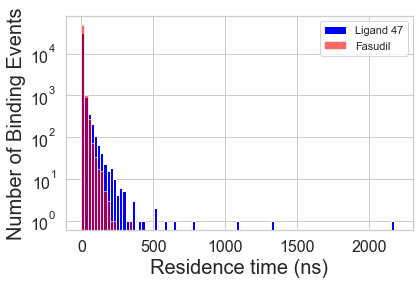

In [299]:

x0=0
xmax=2200
plt.clf()
n_bins=100
histogram=plt.hist(L47_res_time_ns,range=[x0,xmax],color="blue",alpha=1.0,bins=n_bins,label="Ligand 47")
histogram=plt.hist(Fas_res_time_ns,range=[x0,xmax],color="red",alpha=0.6,bins=n_bins,label="Fasudil")

plt.legend()
plt.yticks(fontsize=16) 
plt.xticks(fontsize=16) 
plt.xlabel('Residence time (ns)',fontsize=20)
plt.ylabel('Number of Binding Events',fontsize=20)
plt.yscale("log")
plt.tight_layout()
#plt.xlim(0,500)

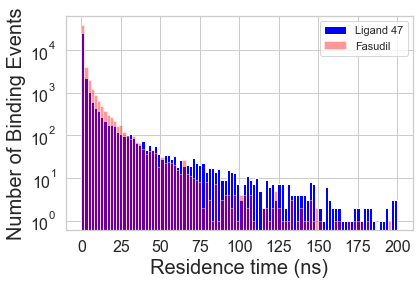

In [297]:

x0=0
xmax=200
plt.clf()
n_bins=100
histogram=plt.hist(L47_res_time_ns,range=[x0,xmax],color="blue",alpha=1.0,bins=n_bins,label="Ligand 47")
histogram=plt.hist(Fas_res_time_ns,range=[x0,xmax],color="red",alpha=0.4,bins=n_bins,label="Fasudil")

plt.legend()
plt.yticks(fontsize=16) 
plt.xticks(fontsize=16) 
plt.xlabel('Residence time (ns)',fontsize=20)
plt.ylabel('Number of Binding Events',fontsize=20)
plt.yscale("log")
plt.tight_layout()
#plt.xlim(0,500)